In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')
plt.rc('font', family='AppleGothic')

In [4]:
df = pd.read_csv('./data/25_0.99.csv', encoding='utf-8')
use_cols = ['총인구수(명)', '유치원 수', '초등학교 수', '출생건수', '사망건수', '혼인건수', '이혼건수', '학령인구(명)']

In [5]:
df

,행정구역(시도),행정구역(시군구),연도,총인구수(명),유치원 수,초등학교 수,출생건수,사망건수,혼인건수,이혼건수,학령인구(명),총인구수-학령인구(명),행정구역
0,서울특별시,종로구,2010,172726.339307,17.207303,14.099772,1131.225264,858.836789,1027.057757,400.418411,29164,143148.034810,서울특별시 종로구
1,서울특별시,중구,2010,135371.879218,13.246087,12.118332,1193.321585,679.681237,1064.583520,382.528583,19628,115229.132986,서울특별시 중구
2,서울특별시,용산구,2010,246401.718734,19.199748,15.095855,2325.774097,1090.664931,1793.561191,531.297854,37318,208715.862336,서울특별시 용산구
3,서울특별시,성동구,2010,309936.996480,31.065775,20.036777,2892.327396,1229.538600,2309.245108,673.877745,51562,258176.195522,서울특별시 성동구
4,서울특별시,광진구,2010,375938.296324,41.959246,22.030707,3371.468618,1293.039174,2674.059212,811.703659,67422,308398.915752,서울특별시 광진구
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,경상남도,함양군,2022,37708.001579,11.995152,12.996096,76.182877,667.297593,90.021510,60.017565,4135,33570.604395,경상남도 함양군
2895,경상남도,거창군,2022,60160.210000,15.960000,16.960000,174.010000,802.640000,162.270000,93.660000,8548,51656.340000,경상남도 거창군
2896,경상남도,합천군,2022,42024.110000,14.930000,16.920000,96.910000,894.950000,88.670000,70.920000,3385,38644.640000,경상남도 합천군
2897,제주특별자치도,제주시,2022,493389.000000,74.000000,69.000000,2766.000000,3281.000000,2034.000000,1102.000000,84346,409043.000000,제주특별자치도 제주시


In [6]:
df['행정구역'].value_counts()

행정구역
서울특별시 종로구       13
전라북도 장수군        13
충청남도 예산군        13
충청남도 태안군        13
전라북도 전주시        13
                ..
경기도 동두천시        13
경기도 안산시         13
경기도 고양시         13
경기도 과천시         13
제주특별자치도 서귀포시    13
Name: count, Length: 223, dtype: int64

In [7]:
# 데이터 전처리
scaler = MinMaxScaler()
df[use_cols] = scaler.fit_transform(df[use_cols])

In [8]:
# 연도가 2013부터 2020까지인 데이터 추출
filtered_df = df[(df['연도'] >= 2010) & (df['연도'] <= 2021)]

# 결과 출력
print(filtered_df)

     행정구역(시도) 행정구역(시군구)    연도  ...   학령인구(명)   총인구수-학령인구(명)          행정구역
0       서울특별시       종로구  2010  ...  0.116964  143148.034810     서울특별시 종로구
1       서울특별시        중구  2010  ...  0.077754  115229.132986      서울특별시 중구
2       서울특별시       용산구  2010  ...  0.150492  208715.862336     서울특별시 용산구
3       서울특별시       성동구  2010  ...  0.209060  258176.195522     서울특별시 성동구
4       서울특별시       광진구  2010  ...  0.274273  308398.915752     서울특별시 광진구
...       ...       ...   ...  ...       ...            ...           ...
2671     경상남도       함양군  2021  ...  0.015144   33905.401043      경상남도 함양군
2672     경상남도       거창군  2021  ...  0.034021   51899.280000      경상남도 거창군
2673     경상남도       합천군  2021  ...  0.011908   39203.730000      경상남도 합천군
2674  제주특별자치도       제주시  2021  ...  0.352866  406560.000000   제주특별자치도 제주시
2675  제주특별자치도      서귀포시  2021  ...  0.114423  155117.000000  제주특별자치도 서귀포시

[2676 rows x 13 columns]


In [9]:
filtered_df

,행정구역(시도),행정구역(시군구),연도,총인구수(명),유치원 수,초등학교 수,출생건수,사망건수,혼인건수,이혼건수,학령인구(명),총인구수-학령인구(명),행정구역
0,서울특별시,종로구,2010,0.138155,0.077236,0.094170,0.092588,0.120553,0.121569,0.154371,0.116964,143148.034810,서울특별시 종로구
1,서울특별시,중구,2010,0.106660,0.056856,0.075695,0.097762,0.093584,0.126149,0.147131,0.077754,115229.132986,서울특별시 중구
2,서울특별시,용산구,2010,0.200273,0.087487,0.103458,0.192119,0.155451,0.215121,0.207342,0.150492,208715.862336,서울특별시 용산구
3,서울특별시,성동구,2010,0.253842,0.148536,0.149527,0.239324,0.176357,0.278060,0.265049,0.209060,258176.195522,서울특별시 성동구
4,서울특별시,광진구,2010,0.309489,0.204581,0.168118,0.279247,0.185916,0.322586,0.320831,0.274273,308398.915752,서울특별시 광진구
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2671,경상남도,함양군,2021,0.024823,0.050420,0.083880,0.006597,0.080260,0.004776,0.021889,0.015144,33905.401043,경상남도 함양군
2672,경상남도,거창군,2021,0.043825,0.070819,0.120839,0.015161,0.097375,0.013097,0.042290,0.034021,51899.280000,경상남도 거창군
2673,경상남도,합천군,2021,0.028620,0.065571,0.120466,0.005511,0.105023,0.005232,0.024579,0.011908,39203.730000,경상남도 합천군
2674,제주특별자치도,제주시,2021,0.408269,0.390005,0.596736,0.239130,0.425861,0.232139,0.424157,0.352866,406560.000000,제주특별자치도 제주시


In [10]:
# 시퀀스 데이터 생성
def create_sequence_data(data, sequence_length):
    sequences = []
    for region in data['행정구역'].unique().tolist():
        temp_df = data[data['행정구역'] == region]
        if len(temp_df) < sequence_length:
            continue

        temp_df = temp_df[use_cols]
        for i in range(len(temp_df) - sequence_length):
            seq = temp_df[i:i+sequence_length+1]
            sequences.append(seq)
    return np.array(sequences)

In [11]:
sequence_length = 3  # 시퀀스 길이
sequences = create_sequence_data(filtered_df, sequence_length)

In [12]:
sequences.shape

(2007, 4, 8)

In [13]:
# 데이터셋 분리
X = sequences[:, :-1]
y = sequences[:, -1][:, -1]

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)


In [15]:
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values

In [16]:
# MAPE 계산 함수
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

# Specify the number of iterations
num_iterations = 10
mape_list = []
min_mape = float('inf')  # Initialize with positive infinity

for iteration in range(num_iterations):
    # Create the model
    model = Sequential()
    model.add(LSTM(128, activation='tanh', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    # Fit the model with early stopping
    model.fit(X_train, y_train, epochs=1000, verbose=0, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Predict
    predicted_data = model.predict(X_test)
    predicted_data = invTransform(scaler, predicted_data, '학령인구(명)', use_cols).reshape(-1, 1)
    predicted_data = predicted_data.round()
    y_true = invTransform(scaler, y_test, '학령인구(명)', use_cols).reshape(-1, 1)

    # Evaluate MAPE
    mape = calculate_mape(y_true, predicted_data)
    print(f'{iteration}th: Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    mape_list.append(mape)

    # Check if the current MAPE is the new minimum
    if mape < min_mape:
        min_mape = mape
        # Save the model when a new minimum is reached
        model.save('best_model25_0.99.h5')

# Calculate and print the average and minimum MAPE
average_mape = np.mean(mape_list)
print(f'Average Mean Absolute Percentage Error (MAPE) over {num_iterations} iterations: {average_mape:.2f}%')
print(f'Minimum Mean Absolute Percentage Error (MAPE) over {num_iterations} iterations: {min_mape:.2f}%')


13/13 [==============================] - 0s 1ms/step
0th: Mean Absolute Percentage Error (MAPE): 6.09%
13/13 [==============================] - 0s 2ms/step
1th: Mean Absolute Percentage Error (MAPE): 6.37%
13/13 [==============================] - 0s 1ms/step
2th: Mean Absolute Percentage Error (MAPE): 3.21%
13/13 [==============================] - 0s 1ms/step
3th: Mean Absolute Percentage Error (MAPE): 3.14%
13/13 [==============================] - 0s 2ms/step
4th: Mean Absolute Percentage Error (MAPE): 6.47%
13/13 [==============================] - 0s 2ms/step
5th: Mean Absolute Percentage Error (MAPE): 6.44%
13/13 [==============================] - 0s 2ms/step
6th: Mean Absolute Percentage Error (MAPE): 5.90%
13/13 [==============================] - 0s 2ms/step
7th: Mean Absolute Percentage Error (MAPE): 3.18%
13/13 [==============================] - 0s 1ms/step
8th: Mean Absolute Percentage Error (MAPE): 3.30%
13/13 [==============================] - 0s 2ms/step
9th: Mean Absolute P

In [18]:
prediction_df = df[df['연도'].isin([i for i in range(2019, 2023)])]

In [19]:
prediction_df

,행정구역(시도),행정구역(시군구),연도,총인구수(명),유치원 수,초등학교 수,출생건수,사망건수,혼인건수,이혼건수,학령인구(명),총인구수-학령인구(명),행정구역
2007,서울특별시,종로구,2019,0.121940,0.077224,0.085050,0.055586,0.121122,0.069703,0.099178,0.076697,133793.827816,서울특별시 종로구
2008,서울특별시,중구,2019,0.100965,0.061912,0.075787,0.064635,0.092946,0.085618,0.087126,0.049806,115390.259900,서울특별시 중구
2009,서울특별시,용산구,2019,0.186662,0.056963,0.103586,0.108550,0.158873,0.155953,0.144174,0.108666,202832.789124,서울특별시 용산구
2010,서울특별시,성동구,2019,0.246837,0.143373,0.158847,0.180784,0.197906,0.210809,0.206606,0.149069,264499.965618,서울특별시 성동구
2011,서울특별시,광진구,2019,0.289246,0.158760,0.168272,0.161725,0.200341,0.227368,0.232033,0.185660,305920.488267,서울특별시 광진구
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,경상남도,함양군,2022,0.024317,0.050420,0.083880,0.004681,0.091720,0.007204,0.016601,0.014050,33570.604395,경상남도 함양군
2895,경상남도,거창군,2022,0.043247,0.070819,0.120839,0.012832,0.112094,0.016022,0.030217,0.032195,51656.340000,경상남도 거창군
2896,경상남도,합천군,2022,0.027956,0.065520,0.120466,0.006408,0.125990,0.007039,0.021014,0.010966,38644.640000,경상남도 합천군
2897,제주특별자치도,제주시,2022,0.408516,0.369426,0.606060,0.228799,0.485172,0.244466,0.438323,0.343861,409043.000000,제주특별자치도 제주시


In [20]:
predict_sequences = create_sequence_data(prediction_df, sequence_length)

In [21]:
predict_sequences

array([[[0.12193956, 0.07722382, 0.08504976, ..., 0.06970278,
         0.09917833, 0.07669724],
        [0.12033527, 0.07716247, 0.08505862, ..., 0.06650579,
         0.10270258, 0.07237575],
        [0.11637157, 0.07205389, 0.08506505, ..., 0.05570312,
         0.07648958, 0.06836676],
        [0.11359124, 0.07205066, 0.08507191, ..., 0.0566194 ,
         0.07738685, 0.0646867 ]],

       [[0.10096523, 0.06191192, 0.07578655, ..., 0.08561789,
         0.08712586, 0.04980613],
        [0.10016993, 0.06184718, 0.07579461, ..., 0.07711052,
         0.0990445 , 0.04750353],
        [0.09783918, 0.06182574, 0.07579963, ..., 0.0692017 ,
         0.08804341, 0.0447733 ],
        [0.09609374, 0.06181988, 0.07580709, ..., 0.05961665,
         0.07613417, 0.04228977]],

       [[0.18666188, 0.0569633 , 0.10358579, ..., 0.15595261,
         0.14417448, 0.10866642],
        [0.1877913 , 0.05690061, 0.10359447, ..., 0.1403162 ,
         0.13888254, 0.1055538 ],
        [0.18183787, 0.05687808, 0.1

In [22]:
# 데이터셋 분리
predict_X = predict_sequences[:, :-1]
predict_y = predict_sequences[:, -1][:, -1]

In [23]:
predict_X

array([[[0.12193956, 0.07722382, 0.08504976, ..., 0.06970278,
         0.09917833, 0.07669724],
        [0.12033527, 0.07716247, 0.08505862, ..., 0.06650579,
         0.10270258, 0.07237575],
        [0.11637157, 0.07205389, 0.08506505, ..., 0.05570312,
         0.07648958, 0.06836676]],

       [[0.10096523, 0.06191192, 0.07578655, ..., 0.08561789,
         0.08712586, 0.04980613],
        [0.10016993, 0.06184718, 0.07579461, ..., 0.07711052,
         0.0990445 , 0.04750353],
        [0.09783918, 0.06182574, 0.07579963, ..., 0.0692017 ,
         0.08804341, 0.0447733 ]],

       [[0.18666188, 0.0569633 , 0.10358579, ..., 0.15595261,
         0.14417448, 0.10866642],
        [0.1877913 , 0.05690061, 0.10359447, ..., 0.1403162 ,
         0.13888254, 0.1055538 ],
        [0.18183787, 0.05687808, 0.10360308, ..., 0.11825993,
         0.13587852, 0.09938611]],

       ...,

       [[0.03052869, 0.06557096, 0.12046604, ..., 0.01130672,
         0.03031832, 0.01470377],
        [0.02952019, 

In [24]:
predict_y

array([0.0646867 , 0.04228977, 0.0943615 , 0.12830434, 0.15947583,
       0.15883439, 0.16461557, 0.24233665, 0.12972702, 0.15108777,
       0.30837202, 0.23509578, 0.15474316, 0.18207835, 0.29678088,
       0.28152613, 0.18906017, 0.08767162, 0.16144538, 0.18147802,
       0.18175351, 0.27697027, 0.3614059 , 0.38045172, 0.25540803,
       0.009416  , 0.04527905, 0.028873  , 0.04217464, 0.16244865,
       0.1642414 , 0.14601382, 0.14327948, 0.23125537, 0.15606715,
       0.10859652, 0.09932032, 0.10466976, 0.07429596, 0.09146269,
       0.12256839, 0.03697734, 0.06128214, 0.2704243 , 0.29997574,
       0.3362623 , 0.1716344 , 0.08852687, 0.02713782, 0.28344634,
       0.30803074, 0.2613249 , 0.15410583, 0.39705514, 0.0252135 ,
       0.00473267, 0.05073539, 0.18616547, 0.14384691, 0.26654688,
       0.32210129, 0.12451738, 0.12817687, 0.3070398 , 0.24994757,
       0.09525787, 0.12212843, 0.18612435, 0.10066076, 0.16010904,
       0.13690209, 0.75345699, 0.54618158, 0.2699021 , 0.32085

In [25]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_model25_0.99.h5')

7/7 [==============================] - 0s 2ms/step


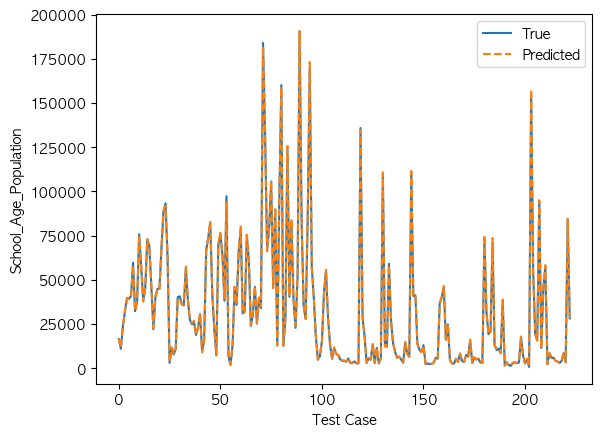

Mean Squared Error: 495815.78
Mean Absolute Percentage Error (MAPE): 2.54%


In [26]:
# 예측
predicted_data = best_model.predict(predict_X)

# 예측 결과 역전환
#predicted_data = scaler.inverse_transform(predicted_data)
predicted_data = invTransform(scaler, predicted_data, '학령인구(명)', use_cols).reshape(-1, 1)
predicted_data = predicted_data.round()
#y_true = scaler.inverse_transform(y_test.reshape(-1, 1))
y_true = invTransform(scaler, predict_y, '학령인구(명)', use_cols).reshape(-1, 1)

# 결과 시각화
plt.plot(range(len(y_true)), y_true, label='True')
plt.plot(range(len(predicted_data)), predicted_data, label='Predicted', linestyle='--')
plt.xlabel('Test Case')
plt.ylabel('School_Age_Population')
plt.legend()
plt.show()

# 모델 평가
mse = mean_squared_error(y_true, predicted_data)
print(f'Mean Squared Error: {mse:.2f}')

# MAPE 계산 함수
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAPE 계산
mape = calculate_mape(y_true, predicted_data)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')